In [1]:
from __future__ import division
import numpy as np
import argparse
import vcf
import itertools
import sys
import multiprocessing
import pandas as pd
from collections import *
from tools.bio import *
from cat.plots import *
from phase_lib import *


def construct_C(inferred_copy_numbers, filtered_features):
    """Construct C based on previous information of counts. Only allow possibilties to be enumerated that match this information"""

    # create map of paralog to inferred total
    inferred_copy_numbers = {x: int(y) for x, y in zip(['AB', 'C', 'D', 'N'], inferred_copy_numbers)}
    total_copies = sum(inferred_copy_numbers.values())
    features_by_paralog = [x.split('_')[1][0] for x in filtered_features.columns]

    # for simplicity, replace all A or B with AB
    features_by_paralog = [x if x not in ['A', 'B'] else 'AB' for x in features_by_paralog]

    # split them into groups, maintaining original positions
    feature_groups = defaultdict(list)
    for i, f in enumerate(features_by_paralog):
        feature_groups[f].append(i)

    # construct all possibilities for each feature group
    possibilities = {}
    for f, positions in feature_groups.iteritems():
        inferred_copy = inferred_copy_numbers[f]
        r = np.array([np.array(x) for x in itertools.product(range(inferred_copy + 1), repeat=len(positions))
                      if sum(x) == inferred_copy])
        possibilities[f] = r


    def array_product(a1, a2):
        m1,n1 = a1.shape
        m2,n2 = a2.shape
        out = np.zeros((m1, m2, n1 + n2), dtype=int)
        out[:,:,:n1] = a1[:,None,:]
        out[:,:,n1:] = a2
        out.shape = (m1 * m2, -1)
        return out

    abc = array_product(possibilities['AB'], possibilities['C'])
    abcd = array_product(abc, possibilities['D'])
    abcdn = array_product(abcd, possibilities['N'])

    # finally, rearrange the columns to reflect the original positioning
    order = feature_groups['AB'] + feature_groups['C'] + feature_groups['D'] + feature_groups['N']
    i = np.argsort(order)
    ordered = abcdn[:,i]
    return ordered



In [2]:
args = argparse.Namespace()
args.features = 'H9_NA12878.features.tsv'
args.inferred_copy_numbers = [4, 2, 2, 2]
args.pileup = 'H9.pileup.txt'
args.bam = None
args.consensus_fasta = '/hive/users/cbosworth/refs/notch/notch2_aligned_consensus.fasta'
args.read_pseudo = 10

In [3]:


data = pd.read_csv(args.pileup, sep='\t', index_col=0)
import cPickle as pickle
C = pickle.load(open('precomputed_C_4_2_2_2.pickle'))
_, seq = read_fasta(args.consensus_fasta, None).next()


In [4]:

features = pd.read_csv(args.features, sep='\t', index_col=0)
# find shared positions in case data is missing some
positions = set(features.index) & set(data['loc'])
filtered_data = data[data['loc'].isin(positions)]
# filter features too
filtered_features = features[features.index.isin(positions)]



In [5]:
def calculate_feature_groups(inferred_copy_numbers, filtered_features):
    # create map of paralog to inferred total
    inferred_copy_numbers = {x: int(y) for x, y in zip(['AB', 'C', 'D', 'N'], inferred_copy_numbers)}
    total_copies = sum(inferred_copy_numbers.values())
    features_by_paralog = [x.split('_')[1][0] for x in filtered_features.columns]

    # for simplicity, replace all A or B with AB
    features_by_paralog = [x if x not in ['A', 'B'] else 'AB' for x in features_by_paralog]

    # split them into groups, maintaining original positions
    feature_groups = defaultdict(list)
    for i, f in enumerate(features_by_paralog):
        feature_groups[f].append(i)
    return feature_groups

In [23]:
feature_groups = calculate_feature_groups(args.inferred_copy_numbers, filtered_features)
# construct pseudocounts bsaed on the features
ab=np.sum(filtered_features[feature_groups['AB']], axis=1)
c=np.sum(filtered_features[feature_groups['C']], axis=1)
d=np.sum(filtered_features[feature_groups['D']], axis=1)
n=np.sum(filtered_features[feature_groups['N']], axis=1)

not_ambig = ((ab>0) & (c==0) & (d==0) & (n==0)) | \
            ((ab==0) & (c>0) & (d==0) & (n==0)) | \
            ((ab==0) & (c==0) & (d>0) & (n==0)) | \
            ((ab==0) & (c==0) & (d==0) & (n>0))

paratype_pseudo = np.asarray(1 - 0.99 * not_ambig)

In [21]:
C = construct_C(args.inferred_copy_numbers, feature_subset)
Ct = C.T

num = np.dot(filtered_features, Ct)
denom = np.sum(Ct, axis=0)

In [22]:

S = (args.paratype_pseudo + num) / (2.0 * args.paratype_pseudo + denom)

S_log = np.log(S)
S_inv = np.log(1 - S)

# M is the number of alt reads, N is the number of ref reads
M = 1.0 * filtered_data.alt_count
N = 1.0 * filtered_data.ref_count
R = np.dot(M + args.read_pseudo, S_log) + np.dot(N + args.read_pseudo, S_inv)

R_map = {i: x for i, x in enumerate(R)}
best_index, score = sorted(R_map.iteritems(), key=lambda x: x[1])[-1]
best_haps = C[best_index]

In [23]:
ordered = sorted(R_map.iteritems(), key=lambda x: x[1])[-10:][::-1]

In [26]:
def calculate_deviance_variance(S, index, filtered_data):
    best_s = S.T[index]
    expected_alt = np.multiply(best_s, filtered_data['coverage'])
    expected_ref = filtered_data['coverage'] - expected_alt
    actual_alt = filtered_data['alt_count']
    actual_ref = filtered_data['ref_count']
    n = filtered_data['coverage']
    deviance = (expected_alt - actual_alt) / (np.sqrt(n * best_s * (1 - best_s)))
    variance = sum(np.multiply(deviance, deviance) ) / len(filtered_data['coverage'])
    return deviance, variance

In [28]:
with open('test.pdf', 'w') as outf, PdfPages(outf) as pdf:
    import matplotlib.pyplot as plt
    for i in xrange(1, 4, 1):
        index = ordered[i][0]
        deviance, variance = calculate_deviance_variance(S, index, filtered_data)
        fig, ax = plt.subplots()
        ax.plot(deviance.index, deviance)
        fig.suptitle('Deviance by position for {} hit {} variance = {}'.format('test', i, variance))
        ax.set_ylim(-70, 10)
        multipage_close(pdf)
        fig, ax = plt.subplots()
        g = sns.distplot(deviance, ax=ax)
        fig.suptitle('Deviance distribution for {} hit {} variance = {}'.format('test', i, variance))
        multipage_close(pdf)

In [40]:
best_s = S.T[best_index]
expected_alt = np.multiply(best_s, filtered_data['coverage'])
expected_ref = filtered_data['coverage'] - expected_alt
actual_alt = filtered_data['alt_count']
actual_ref = filtered_data['ref_count']
#p = expected_alt/(expected_ref + expected_alt)
n = filtered_data['coverage']
deviance = (expected_alt - actual_alt)/ (np.sqrt(n*best_s*(1-best_s)))
variance = sum(np.multiply(deviance, deviance) )/len(filtered_data['coverage'])

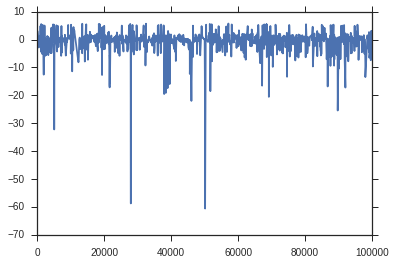

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(deviance.index, deviance)

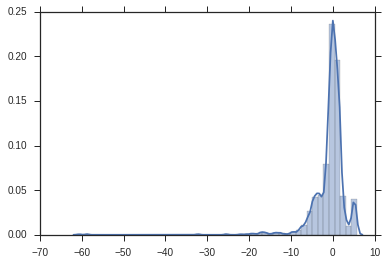

In [46]:
sns.distplot(deviance)

In [44]:
ordered = sorted(R_map.iteritems(), key=lambda x: x[1])[-10:][::-1]
print ' '.join(features.columns)
for i, x in enumerate([[C[pos], pos, val] for pos, val in ordered], 1):
    print '{}: {}'.format(i, x)

CHM1_A_c5_realigned_100kb CHM1_B_c4_realigned_100kb CHM1_N_c3_realigned_100kb NA12878_A1_c7_realigned_100kb NA12878_B1_c3_realigned_100kb NA12878_B2_c5_realigned_100kb NA12878_D2_c6_realigned_100kb NA24385_B1_c4_realigned_100kb NA24385_B2_c5_realigned_100kb NA24385_A1_c0_realigned_100kb NA24385_A2_c6_realigned_100kb NA24385_N1_c3_realigned_100kb NA24385_C1_c2_realigned_100kb H9_A1_c8_realigned_100kb H9_B1_c1_realigned_100kb H9_B2_c3_realigned_100kb H9_B3_c7_realigned_100kb H9_C1_c4_realigned_100kb
1: [array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]), 12415, -149964.17389134428]
2: [array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]), 9400, -150033.3829010363]
3: [array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]), 14935, -150081.87344283704]
4: [array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]), 12541, -150110.59899929177]
5: [array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]), 9139, -150139.94380525083]
6: [array([0, 1, 1, 0, 0,

In [45]:
print 'log odds: {}'.format(score)
print 'results: '
for x, y in zip(filtered_features.columns, best_haps):
    if y > 0:
        print '{}: {}'.format(x, y)

log odds: -149964.173891
results: 
CHM1_A_c5_realigned_100kb: 1
CHM1_N_c3_realigned_100kb: 1
NA12878_D2_c6_realigned_100kb: 1
NA24385_N1_c3_realigned_100kb: 1
NA24385_C1_c2_realigned_100kb: 1
H9_A1_c8_realigned_100kb: 1
H9_B1_c1_realigned_100kb: 1
H9_B2_c3_realigned_100kb: 1
H9_C1_c4_realigned_100kb: 1


In [29]:
%connect_info

{
  "stdin_port": 43186, 
  "ip": "127.0.0.1", 
  "control_port": 55191, 
  "hb_port": 50327, 
  "signature_scheme": "hmac-sha256", 
  "key": "7cddbd48-dfca-44e4-b066-533e360b4dfb", 
  "kernel_name": "", 
  "shell_port": 60760, 
  "transport": "tcp", 
  "iopub_port": 36339
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /cluster/home/ifiddes/.local/share/jupyter/runtime/kernel-a9fbe641-290b-4421-a731-5e47668b937e.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [136]:
# discard largest deviance


def calculate_variance(deviance, filtered_data):
    return  sum(np.multiply(deviance, deviance)) / len(filtered_data['coverage'])


def reject_deviance_outliers(deviance, percent=0.1):
    """Rejects percent of lowest deviance values, returns the worst"""
    s = len(deviance)
    d = int(round(percent * s))
    indices = deviance.argsort()[:d]
    return indices


def calculate_mask(S, filtered_data):
    """Constructs the masking matrix based on deviance"""
    masked = []
    for s in S.T:
        deviance = calculate_deviance(s, filtered_data)
        to_mask = set(reject_deviance_outliers(deviance))
        mask = [0 if x in to_mask else 1 for x in range(len(s))]
        masked.append(mask)
    return np.array(mask).T


def calculate_values(filtered_features, C, S, S_mask):
    """Calculate S and the vector R. If mask is not None, will mask S_log and S_inv with it"""
    Ct = C.T
    num = np.dot(filtered_features, Ct)
    denom = np.sum(Ct, axis=0)

    S = (args.paratype_pseudo + num) / (2.0 * args.paratype_pseudo + denom)

    S_log = np.log(S)
    S_inv = np.log(1 - S)
    # mask these matrices
    S_log = np.multiply(S_log, S_mask)
    S_inv = np.multiply(S_log, S_mask)

    # M is the number of alt reads, N is the number of ref reads
    M = 1.0 * filtered_data.alt_count
    N = 1.0 * filtered_data.ref_count
    R = np.dot(M + args.read_pseudo, S_log) + np.dot(N + args.read_pseudo, S_inv)
    return R



In [137]:

R = calculate_values(filtered_features, C, S, S_mask)

R_map = {i: x for i, x in enumerate(R)}
best_index, score = sorted(R_map.iteritems(), key=lambda x: x[1])[-1]
best_haps = C[best_index]
ordered = sorted(R_map.iteritems(), key=lambda x: x[1])[-10:][::-1]




In [138]:


print 'log odds: {}'.format(score)
print ''
print 'results: '
for x, y in zip(filtered_features.columns, best_haps):
    if y > 0:
        print '{}: {}'.format(x, y)

log odds: -380669.833593

results: 
NA12878_D2_c6: 1
NA24385_B1_c4: 1
NA24385_N1_c3: 2
NA24385_C1_c2: 2
H9_B1_c1: 1
H9_B2_c3: 1
H9_B3_c7: 1


In [154]:
S_masked = np.multiply(S, S_mask)

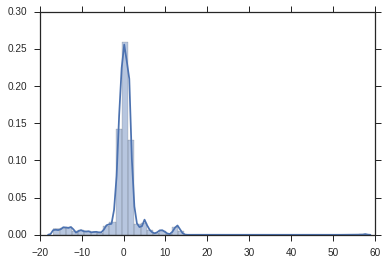

In [163]:
%matplotlib inline
deviance = calculate_deviance(S_masked.T[0], filtered_data)
deviance = deviance.replace([np.inf, -np.inf], np.nan)
sns.distplot(deviance.dropna())

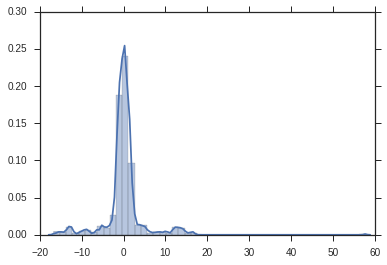

In [182]:
d = randomize_histogram(deviance)
sns.distplot(d.dropna())

In [7]:
%connect_info

{
  "stdin_port": 57559, 
  "ip": "127.0.0.1", 
  "control_port": 59295, 
  "hb_port": 54847, 
  "signature_scheme": "hmac-sha256", 
  "key": "05ce056d-9952-4d49-bc60-a6fd6a1b0c3b", 
  "kernel_name": "", 
  "shell_port": 42981, 
  "transport": "tcp", 
  "iopub_port": 34857
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /cluster/home/ifiddes/.local/share/jupyter/runtime/kernel-70c0b7a6-1635-4cf7-b985-bd8b78162de6.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [54]:
args = argparse.Namespace()
features = '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/very_reduced.features.tsv'
#args.features="onlyStop.features.tsv"
#args.features="/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/H9_NA12878.features.tsv"
args.features="/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/very_reduced.features.tsv"
args.ratio_plot="tmp.pdf"
args.inferred_copy_numbers=[4,2,1,2]
#args.bam="/hive/users/cbosworth/SimonsNormals/secondTry/LP6005442-DNA_B08.sorted.2.bam"
#args.bam="H9/E2del68_E2del19N_combined.100kb.sorted.bam"
args.bam=None
args.paratype_pseudo=0.01
args.read_pseudo=0
args.consensus_fasta='/hive/users/cbosworth/refs/notch/notch2_aligned_consensus.fasta'
args.pileup_converter='/cluster/home/ifiddes/pileup2base/pileup2base.pl'
args.save_pileup=None
#args.pileup=None  
args.pileup='/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/H9.pileup.txt'
data = pd.read_csv(args.pileup, sep='\t', index_col=0)
features = pd.read_csv(args.features, sep='\t', index_col=0)

In [56]:
positions = set(features.index) & set(data['loc'])
filtered_data = data[data['loc'].isin(positions)]
# filter features too
filtered_features = features[features.index.isin(positions)]

In [58]:
feature_groups = calculate_feature_groups(args.inferred_copy_numbers, filtered_features)
# construct pseudocounts bsaed on the features
ab=np.sum(filtered_features[feature_groups['AB']], axis=1)
c=np.sum(filtered_features[feature_groups['C']], axis=1)
d=np.sum(filtered_features[feature_groups['D']], axis=1)
n=np.sum(filtered_features[feature_groups['N']], axis=1)

not_ambig = ((ab>0) & (c==0) & (d==0) & (n==0)) | \
            ((ab==0) & (c>0) & (d==0) & (n==0)) | \
            ((ab==0) & (c==0) & (d>0) & (n==0)) | \
            ((ab==0) & (c==0) & (d==0) & (n>0))

paratype_pseudo = np.array([0.01 if x else 1 for x in not_ambig])

In [60]:
C = pickle.load(open('very_reduced.features.precomputed_C_4_2_1_2.pickle'))

In [72]:
def calculate_deviance(s, filtered_data):
    expected_alt = np.multiply(s, filtered_data['coverage'])
    expected_ref = filtered_data['coverage'] - expected_alt
    actual_alt = filtered_data['alt_count']
    actual_ref = filtered_data['ref_count']
    n = filtered_data['coverage']
    deviance = (expected_alt - actual_alt) / (np.sqrt(n * s * (1 - s)))
    return deviance


def filter_deviance(deviance):
    """Remove NaN from deviance. Used for plotting"""
    return deviance.replace([np.inf, -np.inf], np.nan).dropna()


def randomize_histogram(deviance):
    """Multiply deviance vector by coin toss vector"""
    v = [random.choice([-1, 1]) for _ in range(len(deviance))]
    return np.multiply(deviance, v)


def calculate_variance(deviance, filtered_data):
    return sum(np.multiply(deviance, deviance)) / len(filtered_data['coverage'])


def reject_deviance_outliers(deviance, percent=0.01):
    """Rejects percent of lowest deviance values, returns the worst"""
    s = len(deviance)
    d = int(round(percent * s))
    indices = deviance.argsort()[:d]
    return indices


def calculate_mask(S, filtered_data):
    """Constructs the masking matrix based on deviance"""
    masked = []
    for s in S.T:
        deviance = calculate_deviance(s, filtered_data)
        to_mask = set(reject_deviance_outliers(deviance))
        mask = [0 if x in to_mask else 1 for x in range(len(s))]
        masked.append(mask)
    return np.array(masked).T


def calculate_values(filtered_features, C, paratype_pseudo, read_pseudo):
    """Calculate S and the vector R."""
    Ct = C.T

    num = np.dot(filtered_features, Ct)
    denom = np.sum(Ct[:,0])  # first column -- all columns sum to total number of copies
    paratype_pseudo += denom
    S = (paratype_pseudo + num.T) / ( (2.0 * paratype_pseudo) + denom)
    S = S.T

    #num = np.dot(filtered_features, Ct)
    #denom = np.sum(Ct, axis=0)
    #S = (1 + num) / (2.0 * 1 + denom)

    S_log = np.log(S)
    S_inv = np.log(1 - S)
    # calculate the masking matrix based on deviance
    #S_mask = calculate_mask(S, filtered_data)
    # mask these matrices
    #S = np.multiply(S, S_mask)
    #S_log = np.multiply(S_log, S_mask)
    #S_inv = np.multiply(S_log, S_mask)

    # M is the number of alt reads, N is the number of ref reads
    M = 1.0 * filtered_data.alt_count
    N = 1.0 * filtered_data.ref_count
    R = (np.dot(M + read_pseudo, S_log) + np.dot(N + read_pseudo, S_inv))
    return S, R

S, R = calculate_values(filtered_features, C, paratype_pseudo, args.read_pseudo)

In [73]:
R_map = {i: x for i, x in enumerate(R)}
best_index, score = sorted(R_map.iteritems(), key=lambda x: x[1])[-1]
best_haps = C[best_index]
ordered = sorted(R_map.iteritems(), key=lambda x: x[1])[-10:][::-1]


In [74]:
print 'log odds: {}'.format(score)
print ''
print 'results: '
for x, y in zip(filtered_features.columns, best_haps):
    if y > 0:
        print '{}: {}'.format(x, y)

log odds: -2125703.35075

results: 
CHM1_A_c5: 2
CHM1_N_c3: 1
NA12878_A1_c7: 2
NA12878_D2_c6: 1
NA24385_N1_c3: 1
NA24385_C1_c2: 2
